In [1]:
import json
import os
from io import BytesIO

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import oci
from PIL import Image

In [65]:
config = oci.config.from_file()

In [66]:
#Object storage Namespace
object_storage_client = oci.object_storage.ObjectStorageClient(config)
NAMESPACE = object_storage_client.get_namespace().data

#Name of Bucket for this demo
BUCKET_NAME = 'bucket-pruebas'

PREFIX = "notebook"

In [67]:
type(object_storage_client)

oci.object_storage.object_storage_client.ObjectStorageClient

In [100]:
DATASET_PATH = "./sample_documents"
FILENAME = "image3.png"

In [101]:
response = object_storage_client.put_object(NAMESPACE, BUCKET_NAME, FILENAME, open(os.path.join(DATASET_PATH, FILENAME), "rb"))
response.status

200

In [102]:
response = object_storage_client.get_object(NAMESPACE, BUCKET_NAME, FILENAME)
response.status

200

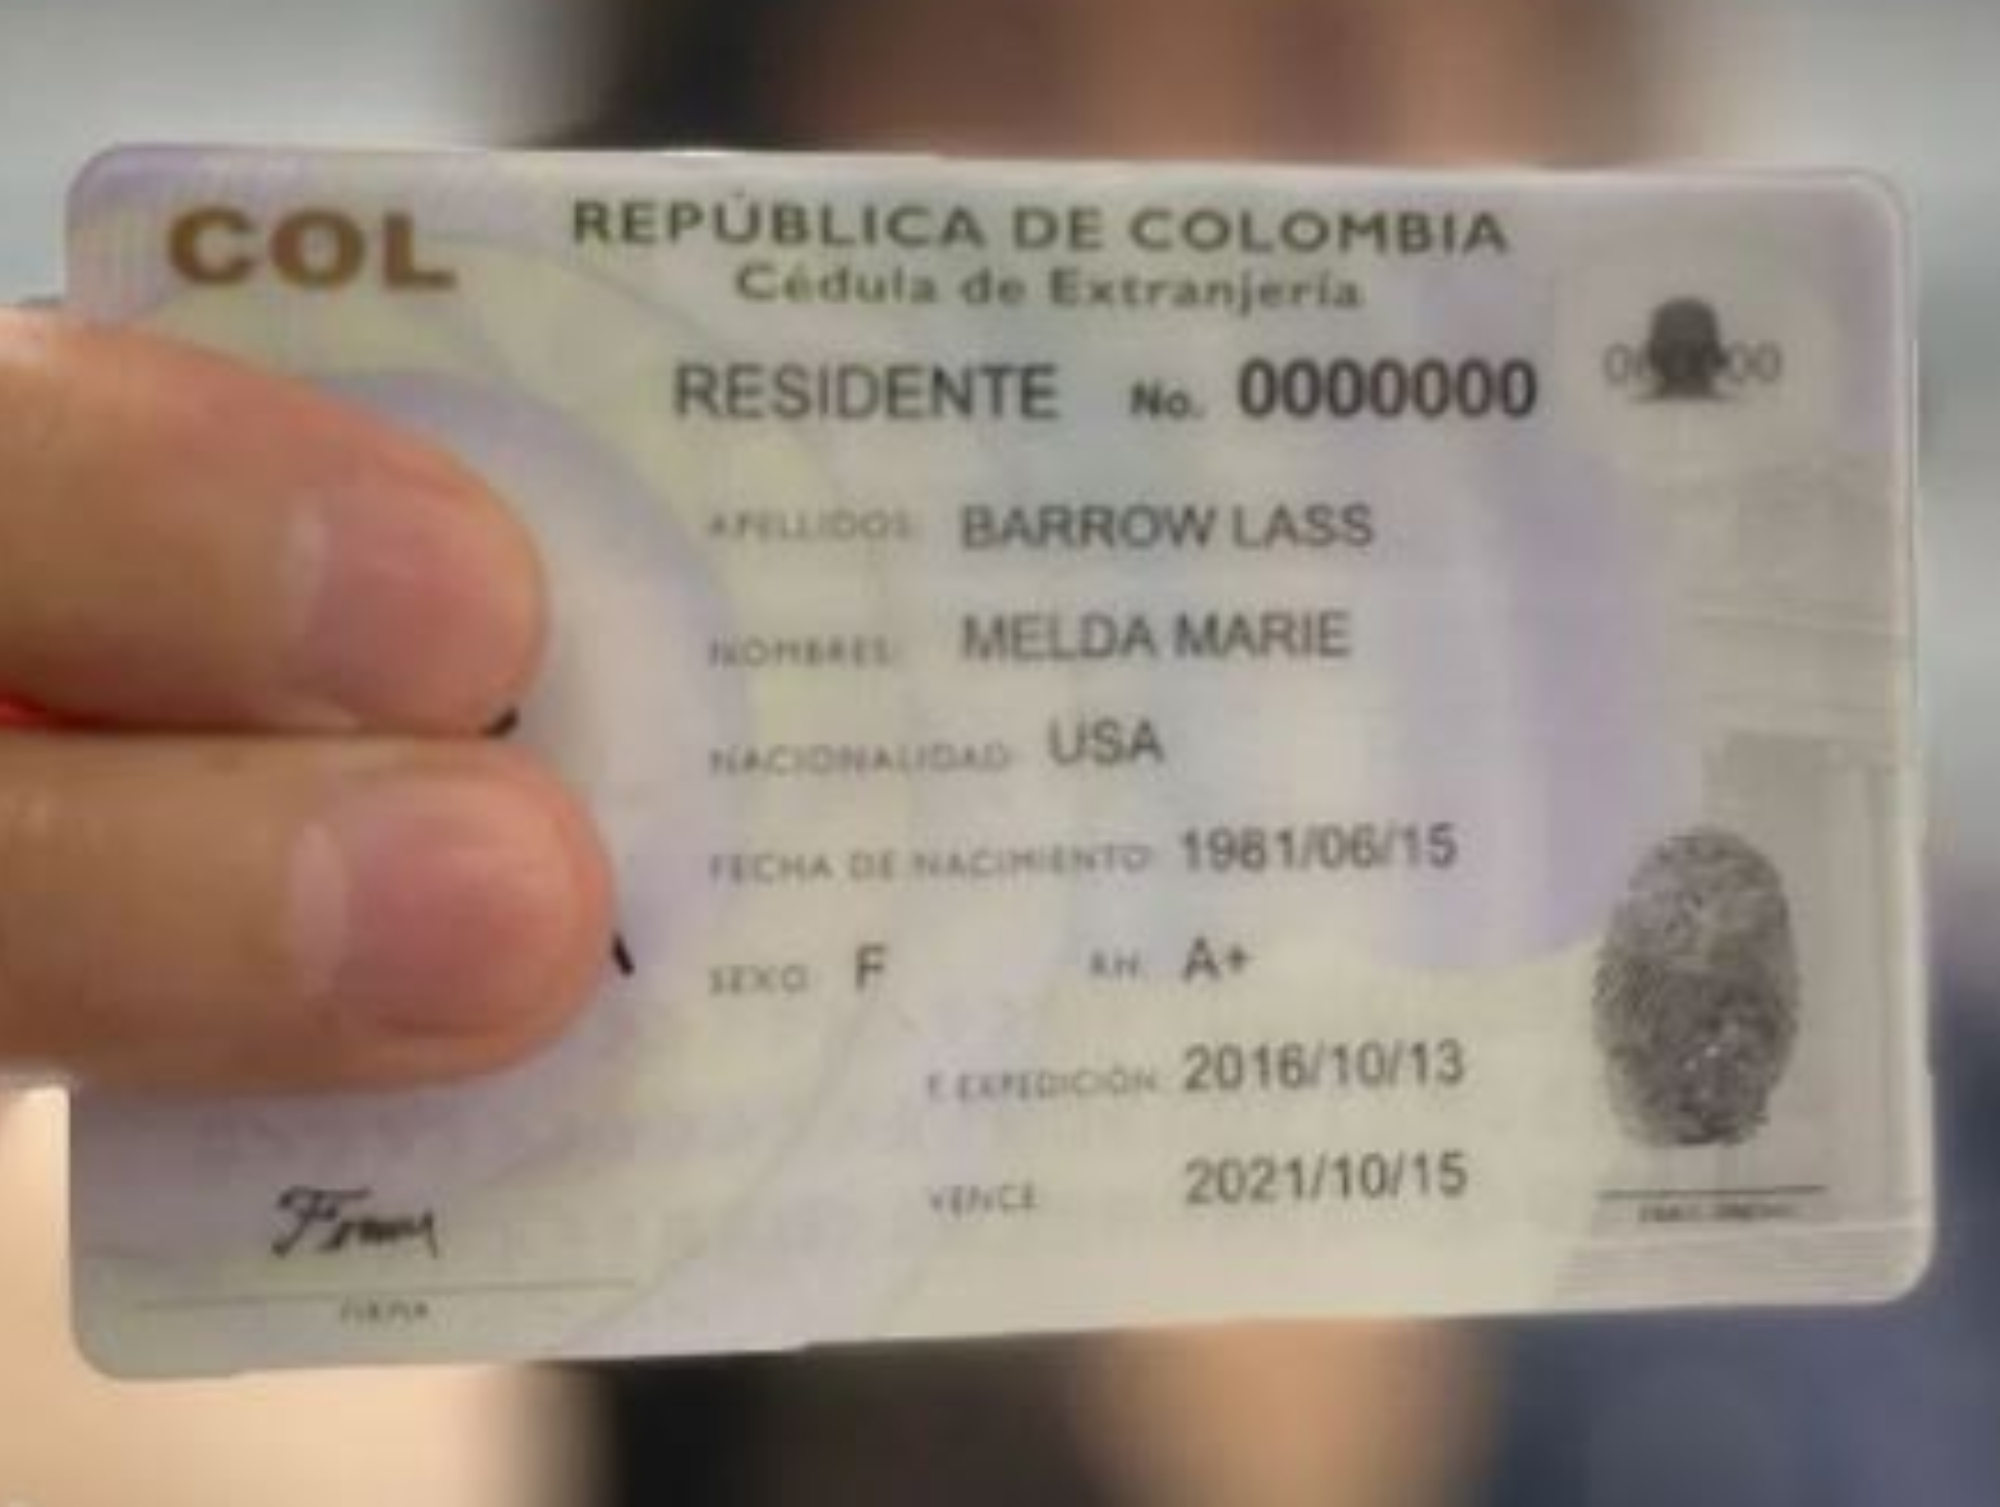

In [103]:
image = Image.open(BytesIO(response.data.content))
image

In [104]:
# Initialize service client with default config file
ai_document_client = oci.ai_document.AIServiceDocumentClient(config)

In [105]:
# Send the request to service, some parameters are not required, see API
# doc for more info
create_processor_job_response = ai_document_client.create_processor_job(
    create_processor_job_details=oci.ai_document.models.CreateProcessorJobDetails(
        input_location=oci.ai_document.models.ObjectStorageLocations(
            source_type="OBJECT_STORAGE_LOCATIONS",
            object_locations=[
                oci.ai_document.models.ObjectLocation(
                    namespace_name=NAMESPACE,
                    bucket_name=BUCKET_NAME,
                    object_name=FILENAME)]),
        output_location=oci.ai_document.models.OutputLocation(
            namespace_name=NAMESPACE,
            bucket_name=BUCKET_NAME,
            prefix=PREFIX),
        compartment_id=config["compartment_id"],
        processor_config=oci.ai_document.models.GeneralProcessorConfig(
            processor_type="GENERAL",
            features=[
                oci.ai_document.models.DocumentTextExtractionFeature(
                    feature_type="TEXT_EXTRACTION",
                    generate_searchable_pdf=True)],
            document_type="OTHERS",
            is_zip_output_enabled=True,
            language="es"),
        display_name="EXAMPLE-displayName-Value"),
    opc_retry_token="EXAMPLE-opcRetryToken-Value",
    opc_request_id="MOZIJVR14UCLBIBEOUH8<unique_ID>")


In [106]:
time_accepted = create_processor_job_response.data.time_accepted
time_started = create_processor_job_response.data.time_started
time_finished = create_processor_job_response.data.time_finished

# Calculate the time taken to process the document
time_taken = time_finished - time_started
print("It took {} seconds to process the document".format(time_taken.total_seconds()))

It took 0.0 seconds to process the document


In [107]:
output_location = "{}_{}".format(create_processor_job_response.data.output_location.namespace_name, create_processor_job_response.data.output_location.bucket_name)

In [108]:
results_path = os.path.join(PREFIX, create_processor_job_response.data.id, output_location, "results", FILENAME+".json")

In [109]:
response = object_storage_client.get_object(NAMESPACE, BUCKET_NAME, results_path)
response.status

200

In [110]:
bytes_json = response.data.content
json_data = json.loads(bytes_json)
json_data

{'documentMetadata': {'pageCount': 1, 'mimeType': 'image/png'},
 'pages': [{'pageNumber': 1,
   'dimensions': {'width': 2000.0, 'height': 1507.0, 'unit': 'PIXEL'},
   'detectedDocumentTypes': None,
   'detectedLanguages': None,
   'words': [{'text': 'COL',
     'confidence': 0.98602766,
     'boundingPolygon': {'normalizedVertices': [{'x': 0.075,
        'y': 0.12209688122096882},
       {'x': 0.236, 'y': 0.12740544127405443},
       {'x': 0.2345, 'y': 0.20437956204379562},
       {'x': 0.0735, 'y': 0.19907100199071}]}},
    {'text': 'REPUBLICA',
     'confidence': 0.98261696,
     'boundingPolygon': {'normalizedVertices': [{'x': 0.2845,
        'y': 0.12411829107394658},
       {'x': 0.484, 'y': 0.12718076142714207},
       {'x': 0.4835073547363281, 'y': 0.171639951871734},
       {'x': 0.2840073547363281, 'y': 0.1685774815185385}]}},
    {'text': 'DE',
     'confidence': 0.98261696,
     'boundingPolygon': {'normalizedVertices': [{'x': 0.495,
        'y': 0.12734962063430552},
      

In [111]:
dimensions = json_data["pages"][0]["dimensions"]

width = dimensions["width"]
height = dimensions["height"]

dimensions

{'width': 2000.0, 'height': 1507.0, 'unit': 'PIXEL'}

In [112]:
words = json_data["pages"][0]["words"]
words

[{'text': 'COL',
  'confidence': 0.98602766,
  'boundingPolygon': {'normalizedVertices': [{'x': 0.075,
     'y': 0.12209688122096882},
    {'x': 0.236, 'y': 0.12740544127405443},
    {'x': 0.2345, 'y': 0.20437956204379562},
    {'x': 0.0735, 'y': 0.19907100199071}]}},
 {'text': 'REPUBLICA',
  'confidence': 0.98261696,
  'boundingPolygon': {'normalizedVertices': [{'x': 0.2845,
     'y': 0.12411829107394658},
    {'x': 0.484, 'y': 0.12718076142714207},
    {'x': 0.4835073547363281, 'y': 0.171639951871734},
    {'x': 0.2840073547363281, 'y': 0.1685774815185385}]}},
 {'text': 'DE',
  'confidence': 0.98261696,
  'boundingPolygon': {'normalizedVertices': [{'x': 0.495,
     'y': 0.12734962063430552},
    {'x': 0.553, 'y': 0.12823996641972876},
    {'x': 0.55250732421875, 'y': 0.17269915686432066},
    {'x': 0.4945073547363281, 'y': 0.17180880095362266}]}},
 {'text': 'COLOMBIA',
  'confidence': 0.98261696,
  'boundingPolygon': {'normalizedVertices': [{'x': 0.5585,
     'y': 0.1283243909606731}

In [113]:
def xyxy_to_xywh(x1, y1, x2, y2):
    return x1, y1, x2 - x1, y2 - y1

def xyxy_to_cxcywh(x1, y1, x2, y2):
    return (x1 + x2) / 2, (y1 + y2) / 2, x2 - x1, y2 - y1

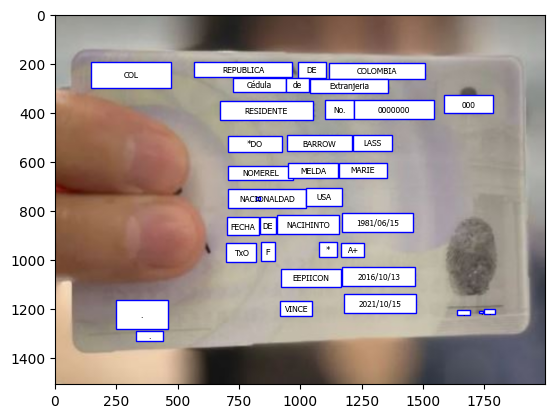

In [114]:
fig, ax = plt.subplots()

ax.imshow(image)

for word in words:
    x, y, w, h = xyxy_to_xywh(word["boundingPolygon"]["normalizedVertices"][1]["x"], word["boundingPolygon"]["normalizedVertices"][1]["y"],
                                word["boundingPolygon"]["normalizedVertices"][3]["x"], word["boundingPolygon"]["normalizedVertices"][3]["y"])
    
    cx, cy, w, h = xyxy_to_cxcywh(word["boundingPolygon"]["normalizedVertices"][1]["x"], word["boundingPolygon"]["normalizedVertices"][1]["y"],
                                word["boundingPolygon"]["normalizedVertices"][3]["x"], word["boundingPolygon"]["normalizedVertices"][3]["y"])
    
    rect = patches.Rectangle((x * width, y * height), w * width, h * height, linewidth=1, edgecolor='blue', facecolor='white')

    ax.text(cx * width, cy * height, word["text"], horizontalalignment='center',
    verticalalignment='center', fontsize=6, color='black', fontfamily="Tahoma")
    # Add the patch to the Axes
    ax.add_patch(rect)

plt.savefig('output.png')
plt.show()
